# Conductance-Based Spiking Neural Network

Initialize parameters

In [116]:
import numpy as np
import pylab as pl
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation

In [117]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

## Single-neuron

Initialize parameters

$\frac{dV}{dt} = -V + \Gamma c + \Gamma^{2} \cdot (V - E) \cdot o$

In [118]:
def initialize_params_single(dt, iterations, gamma):
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike train
    o = np.zeros(iterations)

    # voltage
    voltage = np.zeros(iterations)

    # threshold
    T = (gamma**2) / 2

    # spike times
    spike = []
    t_spike = []
    
    return (t, x_est, o, voltage, T, spike, t_spike) 

Create time varying signal

In [119]:
def TVS_single():
    
    # create time-varying signal
    x = 5
    x_t = np.ones(iterations) * x

    step = 100
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 3

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

Run simulation

In [168]:
def run_single(E):
    for t in range(1, iterations):

        # udpate input estimate
        dxestdt = -x_est[t - 1] + gamma * o[t - 1]
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltage
        dVdt = -voltage[t - 1] + gamma * c[t - 1] - o[t - 1] * (voltage[t - 1] - E) * (gamma ** 2)
        voltage[t] = voltage[t - 1] + dt * dVdt

        # spike when voltage exceeds threshold
        if voltage[t] > T:
            o[t] = 1/dt

            # save spike times
            spike.append(1)
            t_spike.append(t)

Plot results (input + input estimate, voltage, spikes)

In [159]:
def plot_single():
    plots = 3
    pl.subplots(plots, 1, figsize=(8, 4))

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.plot(x, label=r'$x$')
    pl.plot(x_est, label=r'$\hat{x}$')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xticks([])
    pl.legend()

    pl.subplot(plots, 1, 2)
    pl.plot(voltage, 'k')
    pl.xlim(0, iterations)
    pl.ylabel('Voltage')
    pl.ylim(-60, 60)
#     pl.yticks([])
#     pl.xticks([])

    pl.subplot(plots, 1, 3)
    pl.scatter(t_spike, spike, c='k')
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xlabel('time')

Runs de simulation

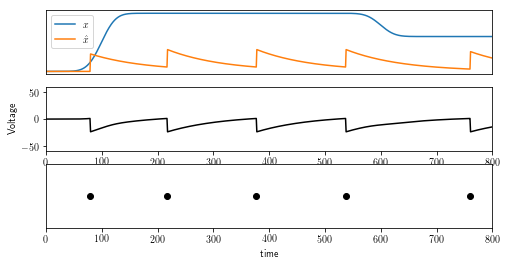

In [183]:
dt = 0.01
iterations = 800
gamma = 1.5
E_e = 20
E_i = -10

t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
x,c = TVS_single()
run_single(E_i)
plot_single()

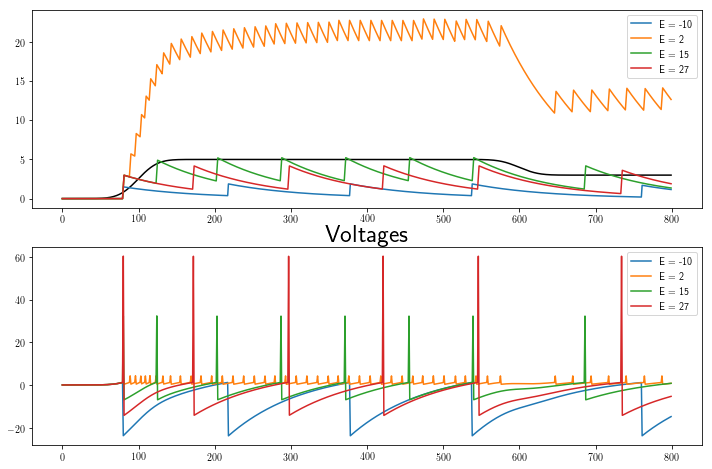

In [198]:
# range 
lines = 4
E = np.linspace(-10, 40, lines + 1)

# time signal
x,c = TVS_single()

# initiate plots
pl.subplots(2, 1, figsize=(12, 8))

# plot input and input estimate
pl.subplot(2, 1, 1)
pl.plot(x, 'k')
for i in range(lines):
    t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
    run_single(E[i])
    pl.plot(x_est, label="E = %i" %E[i])
    pl.legend()

# plot voltages
pl.subplot(2, 1, 2)
pl.title('Voltages', fontsize=25)
for i in range(lines):
    t, x_est, o, voltage, T, spike, t_spike = initialize_params_single(dt, iterations, gamma)
    run_single(E[i])
    pl.plot(voltage, label="E = %i" %E[i])
    pl.legend()
    

## $\textit{N}$-neurons (homogeneous network)

Initialize parameters

In [112]:
def initialize_params_homogeneous(N, dt, iterations, gamma, mu):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    weight = np.ones((1, N)) * gamma
    
#     weight = np.ones((N, N))
#     weight[0][0] = 1
#     weight[0][1] = 0
#     weight[1][0] = -0.1
#     weight[1][1] = 1

    # threshold
    T = (gamma**2) / 2 + mu/2

    return (t, x_est, o, voltage, weight, T) 

Create time varying signal

In [6]:
def TVS_homogeneous():

    # create time-varying signal
    x = 5
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 3

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

Run simulation

In [114]:
def run_homogeneous():
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(weight, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltages
        dVdt = -voltage[:, t - 1] + weight * c[t - 1] - np.dot((weight ** 2) * (voltage[:, t - 1]) + mu, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        above_threshold = []

        for i in range(N): 
            if voltage[i, t] > T:
                above_threshold.append(i)

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

Plot results

In [77]:
def plot_homogeneous():
    plots = N + 2
    pl.subplots(plots, 1, figsize=(8, 12))
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.yticks([])
    pl.xticks([])
    pl.xlim(0, iterations)
    pl.legend()
    
    pl.subplot(plots, 1, 2)
    for i in range(1, N + 1):
        
        values = zero_to_nan(o[i - 1, :] * i)
                
        pl.scatter(np.arange(0, iterations), values, label='Neuron %i' %i)
        pl.yticks([])
        pl.xticks([])
        pl.title('Spike train')
        pl.ylim(0, 100 * N + 100)
        pl.xlim(0, iterations)
        
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    counter = 3

    for i in range(1, N + 1):

        neuron = i + 1

        pl.subplot(plots, 1, counter)
        pl.plot(voltage[i - 1], 'k')
        pl.xlim(0, iterations)
        pl.ylabel('Voltage')
        pl.title('Neuron %i' %i)
#         pl.yticks([])
#         pl.xticks([])

        counter = counter + 1

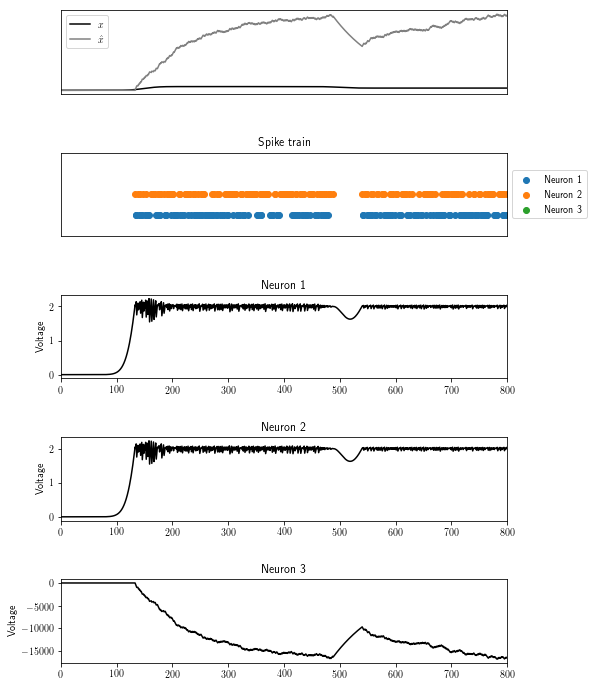

In [115]:
N = 3
dt = 0.01
iterations = 800
gamma = 2
mu = 0 #regularization

# reversal
E = np.zeros((N, 1))

E_e = 2
E_i = -80

E[0] = E_e
E[1] = E_e
E[2] = E_i

t, x_est, o, voltage, weight, T = initialize_params_homogeneous(N, dt, iterations, gamma, mu)
x,c = TVS_homogeneous()
run_homogeneous()
plot_homogeneous()